<a href="https://colab.research.google.com/github/joylin0209/40133HW/blob/main/Joy_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Week 3 - Discovering higher-level Patterns (Topic Modeling & Clustering)

The first 2 weeks have primarily used the word count of documents as their measure, such as counting the number of "positive" and "negative" words to determine sentiment.

This week, we learn a second kind of document representation in clusters or topics. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-b6gi5y32
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-b6gi5y32
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit 9fa6f1abdc19d159d587b4017ee6897fe7a18d4d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian).

In [7]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [8]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [9]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [10]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again.

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram).

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [11]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [12]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [13]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [14]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [15]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms.

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [16]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [17]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [18]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [19]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [20]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [21]:
km.fit(newsgroupsTFVects)

KMeans(n_clusters=4)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*.

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup).

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [22]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'DetCurveDisplay', 'DistanceMetric', 'PrecisionRecallDisplay', 'PredictionErrorDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'class_likelihood_ratios', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'd2_absolute_error_score', 'd2_pinball_score', 'd2_tweedie_score', 'davies_bouldin_score', 'dcg_score', 'det_curve', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'get_scorer_names', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [23]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0


We can also look at the distinguishing features in each cluster:

In [24]:
terms = ngTFVectorizer.get_feature_names_out()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 thanks
 just
 mac
 does
 drive
 like
 apple
 don
 problem


Cluster 1:
 car
 cars
 engine
 like
 just
 good
 think
 dealer
 don
 new


Cluster 2:
 window
 server
 use
 motif
 widget
 using
 program
 application
 like
 code


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 sell
 interested
 price




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [25]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [26]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [27]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

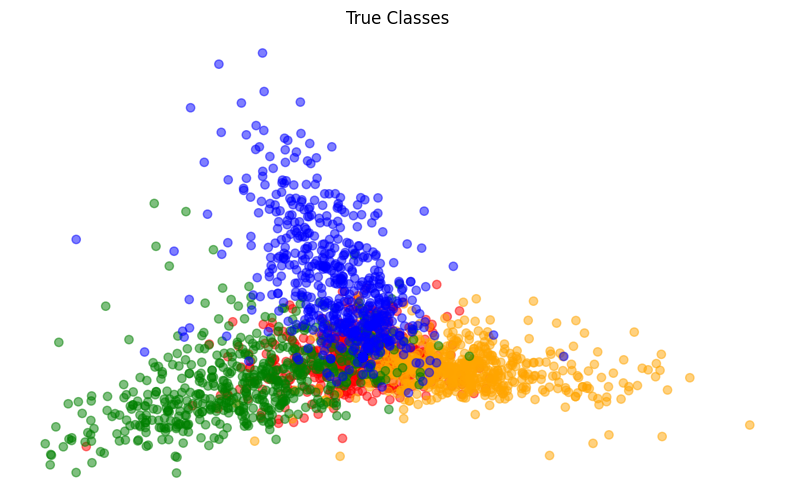

In [28]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

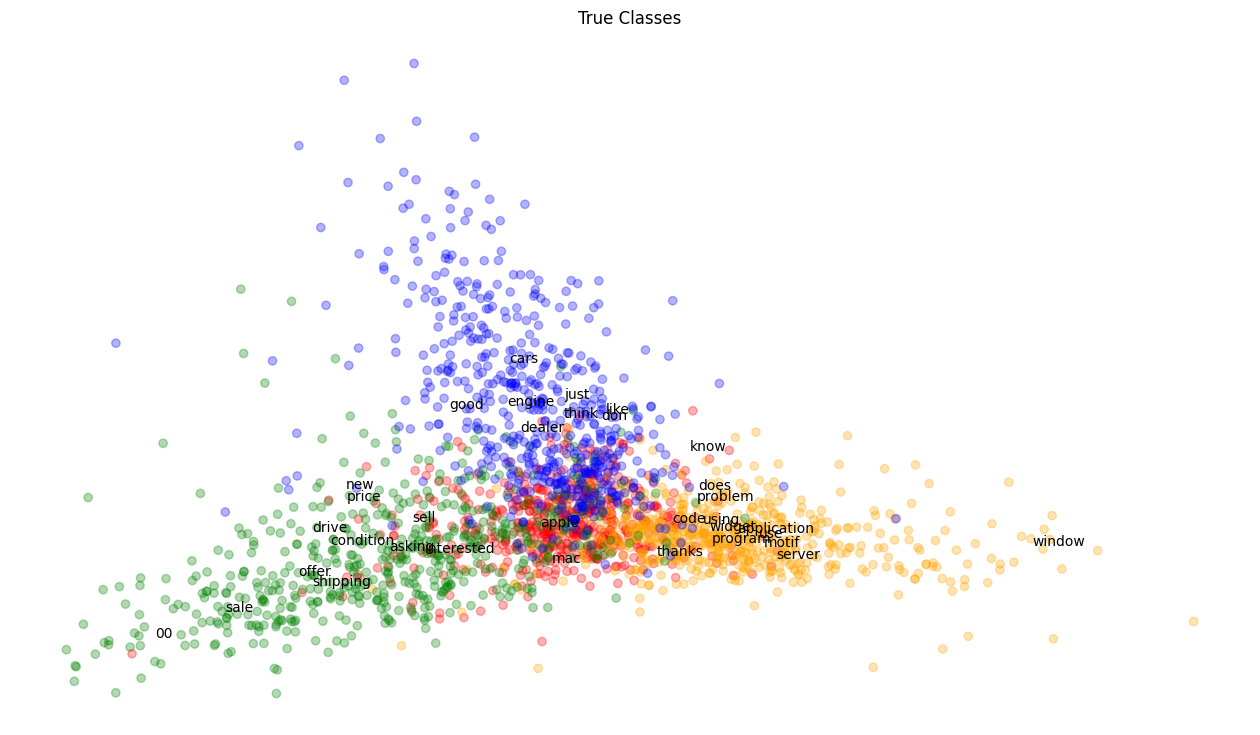

In [29]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [30]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

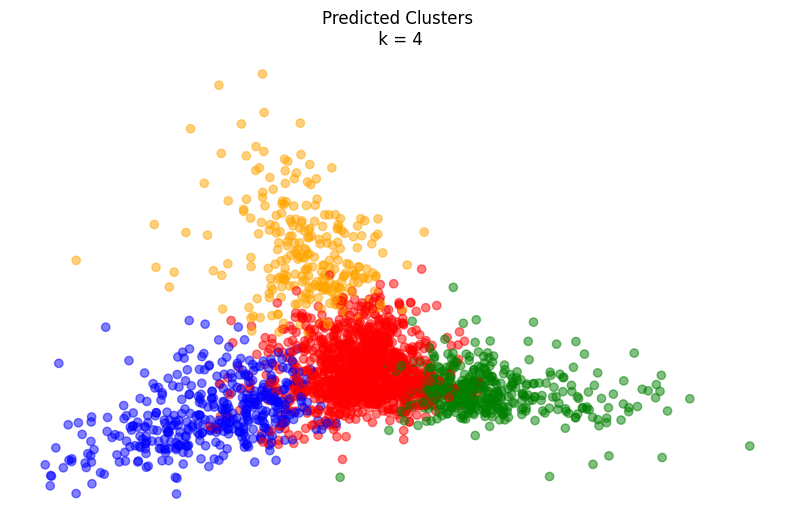

In [31]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [32]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(n_clusters=3)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [33]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

<ipython-input-33-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


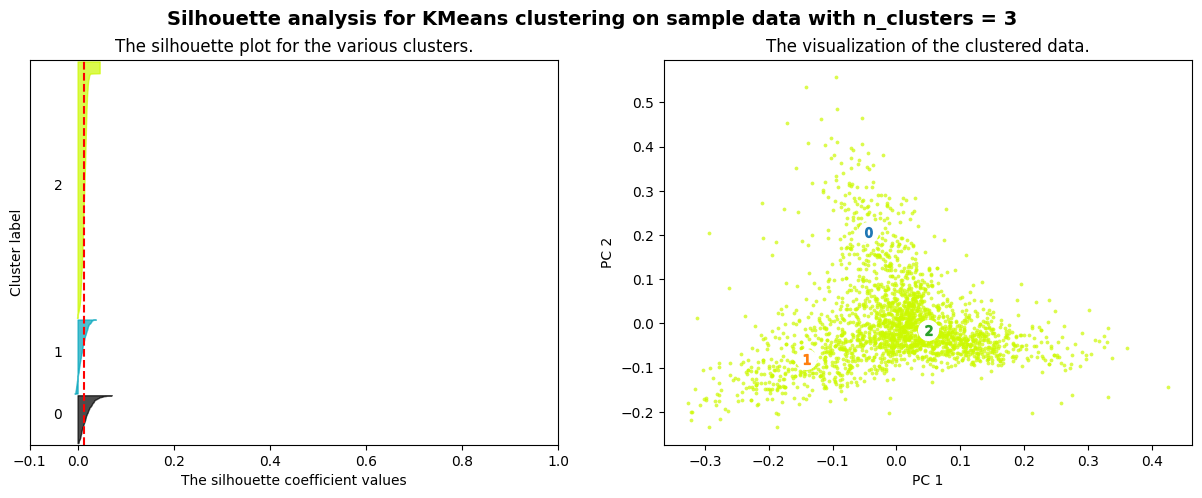

For n_clusters = 3, The average silhouette_score is : 0.014


In [34]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

<ipython-input-33-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


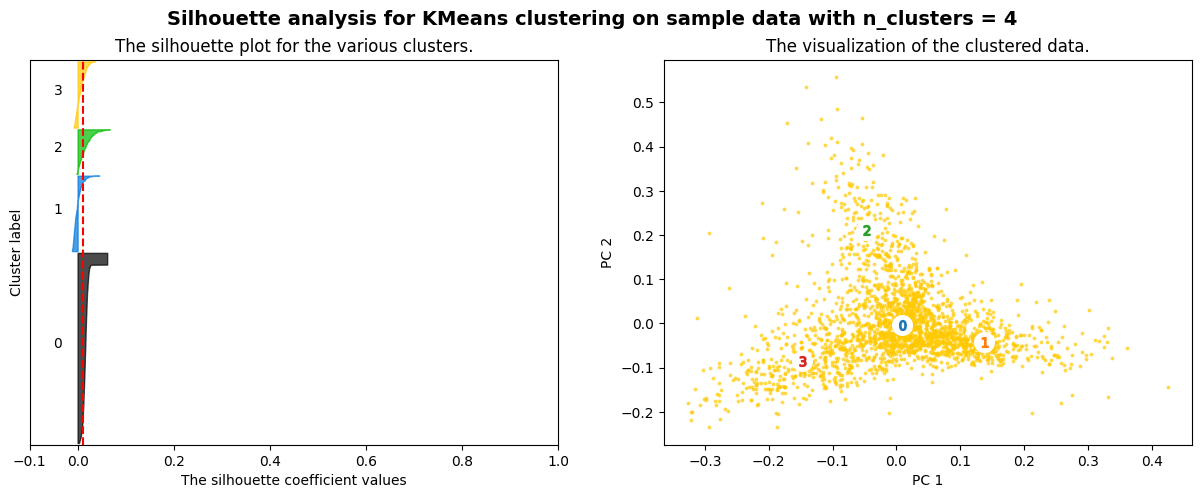

For n_clusters = 4, The average silhouette_score is : 0.012


In [35]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

<ipython-input-33-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


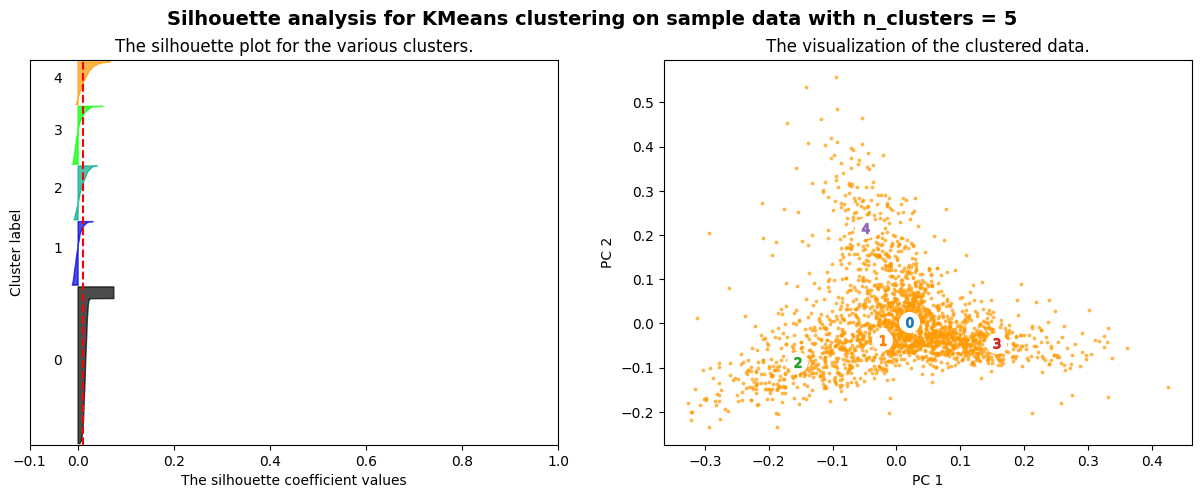

For n_clusters = 5, The average silhouette_score is : 0.011


In [36]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

<ipython-input-33-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


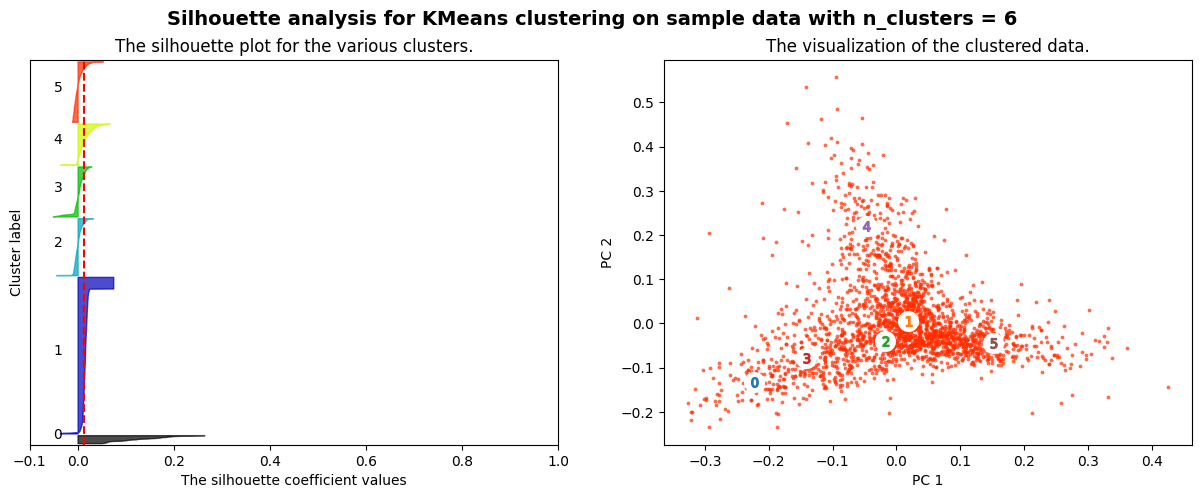

For n_clusters = 6, The average silhouette_score is : 0.013


In [37]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [38]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("/content/drive/MyDrive/SOCI40133/data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [39]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [40]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [41]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [42]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [43]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(n_clusters=3)

And visualize:

In [44]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

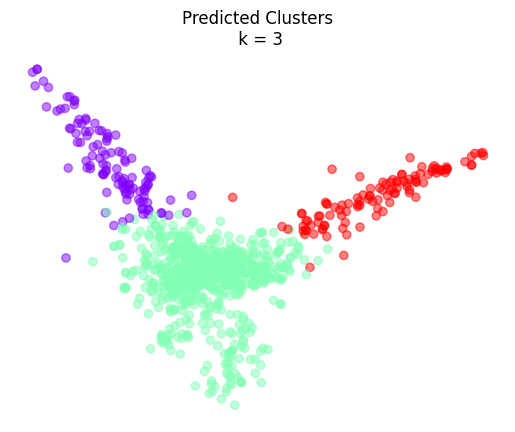

In [45]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [46]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,0
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
...,...,...,...,...,...,...,...,...
994,995,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy13.txt,raw/Kennedy/18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,Kennedy,1
995,996,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy14.txt,raw/Kennedy/18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,Kennedy,1
996,997,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy0.txt,raw/Kennedy/18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
997,998,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy1.txt,raw/Kennedy/18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1


## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora?

First, I fetch data about Senator Bond from GitHub and saving it to a CSV file.

In [47]:
targetSenatorex1 = 'Bond'

#Uncomment this to download your own data
sen_ex1 = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenatorex1))
bondDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenatorex1), maxFiles = 2000)
bondDF['targetSenatorex1'] = targetSenatorex1
sen_ex1= sen_ex1.append(bondDF, ignore_index = True)


sen_ex1.to_csv("/content/drive/MyDrive/SOCI40133/data/sen_ex1.csv")


Fetching Bond's data


In [48]:
sen_ex1= pandas.read_csv("/content/drive/MyDrive/SOCI40133/data/sen_ex1.csv")

sen_ex1[:5]

,Unnamed: 0,name,text,path,html_url,download_url,targetSenatorex1
0,0,10Aug2005Bond136.txt,"\nWASHINGTON, DC – As chairman of the Senate T...",raw/Bond/10Aug2005Bond136.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
1,1,10Aug2005Bond137.txt,"\nWASHINGTON, DC As chairman of the Senate Tr...",raw/Bond/10Aug2005Bond137.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
2,2,10Jan2005Bond4.txt,"\nCOLUMBIA, MO – U.S. Senator Kit Bond today o...",raw/Bond/10Jan2005Bond4.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
3,3,10Jan2006Bond2.txt,\nWASHINGTON - U.S. Representative Jo Ann Emer...,raw/Bond/10Jan2006Bond2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
4,4,10Jun2005Bond88.txt,"\nWASHINTON, DC – U.S. Senator Kit Bond today ...",raw/Bond/10Jun2005Bond88.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond


Then, I load the data from the CSV file and ensure that any rows containing null values are removed.






In [49]:
sen_ex1 = sen_ex1.dropna(axis=0, how='any')
sen_ex1

,Unnamed: 0,name,text,path,html_url,download_url,targetSenatorex1
0,0,10Aug2005Bond136.txt,"\nWASHINGTON, DC – As chairman of the Senate T...",raw/Bond/10Aug2005Bond136.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
1,1,10Aug2005Bond137.txt,"\nWASHINGTON, DC As chairman of the Senate Tr...",raw/Bond/10Aug2005Bond137.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
2,2,10Jan2005Bond4.txt,"\nCOLUMBIA, MO – U.S. Senator Kit Bond today o...",raw/Bond/10Jan2005Bond4.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
3,3,10Jan2006Bond2.txt,\nWASHINGTON - U.S. Representative Jo Ann Emer...,raw/Bond/10Jan2006Bond2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
4,4,10Jun2005Bond88.txt,"\nWASHINTON, DC – U.S. Senator Kit Bond today ...",raw/Bond/10Jun2005Bond88.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
...,...,...,...,...,...,...,...
629,629,9Nov2007Bond208.txt,"\nWASHINGTON, DC - U.S. Senator Kit Bond today...",raw/Bond/9Nov2007Bond208.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
630,630,9Nov2007Bond209.txt,"\nWASHINGTON, DC U.S. Senator Kit Bond today ...",raw/Bond/9Nov2007Bond209.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
631,631,9Oct2007Bond182.txt,"\n ST. LOUIS, MO U.S. Senator Kit Bond was br...",raw/Bond/9Oct2007Bond182.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
632,632,9Oct2007Bond183.txt,"\n WASHINGTON, DC Vice Chairman of the Senate ...",raw/Bond/9Oct2007Bond183.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond


At this point, I use TF-IDF vectorization on the text data.




In [50]:
#Similar parameters to before, but stricter max df and no max num occurrences
senbondTF = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senbondTFvec = senbondTF.fit_transform( sen_ex1['text'])
senbondTF.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

Following that, I perform K-Means clustering, dividing the documents into 3 categories.

In [51]:
bondDF= sen_ex1
textColumn = 'text'
numCategories = 3

In [52]:
bondDF

,Unnamed: 0,name,text,path,html_url,download_url,targetSenatorex1
0,0,10Aug2005Bond136.txt,"\nWASHINGTON, DC – As chairman of the Senate T...",raw/Bond/10Aug2005Bond136.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
1,1,10Aug2005Bond137.txt,"\nWASHINGTON, DC As chairman of the Senate Tr...",raw/Bond/10Aug2005Bond137.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
2,2,10Jan2005Bond4.txt,"\nCOLUMBIA, MO – U.S. Senator Kit Bond today o...",raw/Bond/10Jan2005Bond4.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
3,3,10Jan2006Bond2.txt,\nWASHINGTON - U.S. Representative Jo Ann Emer...,raw/Bond/10Jan2006Bond2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
4,4,10Jun2005Bond88.txt,"\nWASHINTON, DC – U.S. Senator Kit Bond today ...",raw/Bond/10Jun2005Bond88.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
...,...,...,...,...,...,...,...
629,629,9Nov2007Bond208.txt,"\nWASHINGTON, DC - U.S. Senator Kit Bond today...",raw/Bond/9Nov2007Bond208.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
630,630,9Nov2007Bond209.txt,"\nWASHINGTON, DC U.S. Senator Kit Bond today ...",raw/Bond/9Nov2007Bond209.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
631,631,9Oct2007Bond182.txt,"\n ST. LOUIS, MO U.S. Senator Kit Bond was br...",raw/Bond/9Oct2007Bond182.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond
632,632,9Oct2007Bond183.txt,"\n WASHINGTON, DC Vice Chairman of the Senate ...",raw/Bond/9Oct2007Bond183.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond


Later,I use PCA to reduce the TF-IDF vectors to 2 dimensions and visualize the predicted K-Means clustering results.

In [53]:
bondTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
bondTFVects = bondTFVectorizer.fit_transform(bondDF[textColumn])

In [54]:
bondKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
bondKM.fit(bondTFVects)

KMeans(n_clusters=3)

In [55]:
bondPCA = sklearn.decomposition.PCA(n_components = 2).fit(bondTFVects.toarray())
reducedPCA_databond = bondPCA.transform(bondTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in bondKM.labels_]

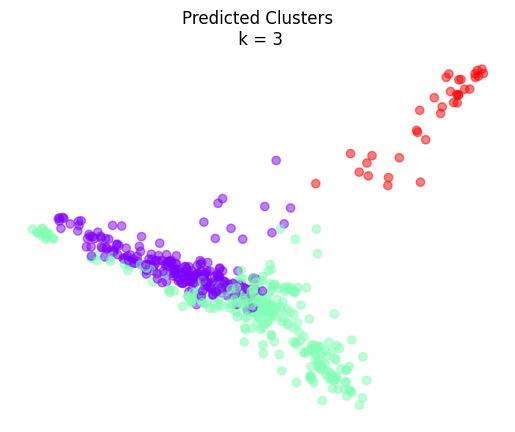

In [56]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_databond[:, 0], reducedPCA_databond[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

 Finally, we add the predicted labels from K-Means clustering to the dataframe and display the dataframe.

In [57]:
bondDF['kmeans_predictions'] = bondKM.labels_
bondDF

,Unnamed: 0,name,text,path,html_url,download_url,targetSenatorex1,kmeans_predictions
0,0,10Aug2005Bond136.txt,"\nWASHINGTON, DC – As chairman of the Senate T...",raw/Bond/10Aug2005Bond136.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,1
1,1,10Aug2005Bond137.txt,"\nWASHINGTON, DC As chairman of the Senate Tr...",raw/Bond/10Aug2005Bond137.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,1
2,2,10Jan2005Bond4.txt,"\nCOLUMBIA, MO – U.S. Senator Kit Bond today o...",raw/Bond/10Jan2005Bond4.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,1
3,3,10Jan2006Bond2.txt,\nWASHINGTON - U.S. Representative Jo Ann Emer...,raw/Bond/10Jan2006Bond2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,1
4,4,10Jun2005Bond88.txt,"\nWASHINTON, DC – U.S. Senator Kit Bond today ...",raw/Bond/10Jun2005Bond88.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,0
...,...,...,...,...,...,...,...,...
629,629,9Nov2007Bond208.txt,"\nWASHINGTON, DC - U.S. Senator Kit Bond today...",raw/Bond/9Nov2007Bond208.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,0
630,630,9Nov2007Bond209.txt,"\nWASHINGTON, DC U.S. Senator Kit Bond today ...",raw/Bond/9Nov2007Bond209.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,1
631,631,9Oct2007Bond182.txt,"\n ST. LOUIS, MO U.S. Senator Kit Bond was br...",raw/Bond/9Oct2007Bond182.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,0
632,632,9Oct2007Bond183.txt,"\n WASHINGTON, DC Vice Chairman of the Senate ...",raw/Bond/9Oct2007Bond183.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,1


# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [58]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [59]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [60]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [61]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [62]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [63]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[126.        , 193.        ,   0.        ,   2.        ],
       [195.        , 200.        ,   0.        ,   3.        ],
       [198.        , 201.        ,   0.        ,   4.        ],
       [ 55.        , 202.        ,   0.37033177,   5.        ],
       [104.        , 169.        ,   0.40914841,   2.        ],
       [ 60.        ,  94.        ,   0.44134524,   2.        ],
       [ 99.        , 162.        ,   0.45096656,   2.        ],
       [151.        , 204.        ,   0.4553535 ,   3.        ],
       [117.        , 206.        ,   0.4650683 ,   3.        ],
       [ 52.        ,  96.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

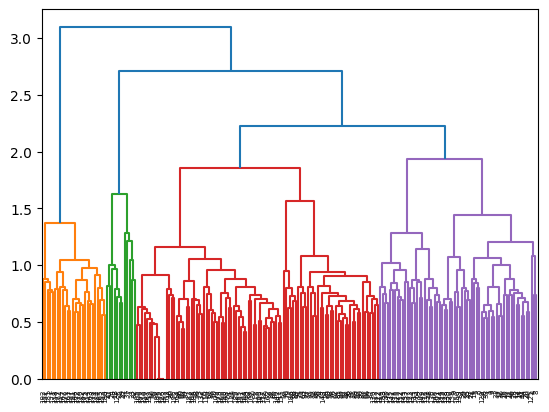

In [64]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

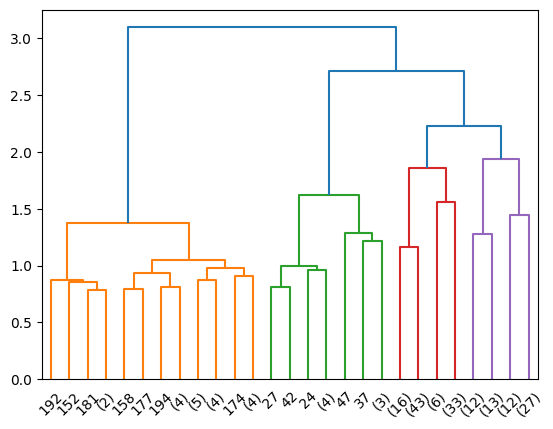

In [65]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [66]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4,
       3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4,
       4, 4, 4, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 1, 1,
       1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [67]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [68]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
...,...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,4
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1,2
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1,2
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [69]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

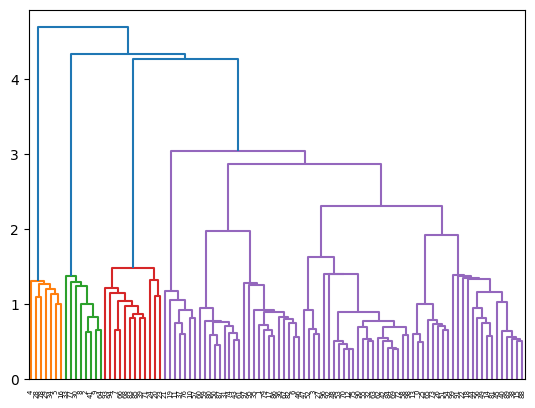

In [70]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix
                                    , truncate_mode='level')

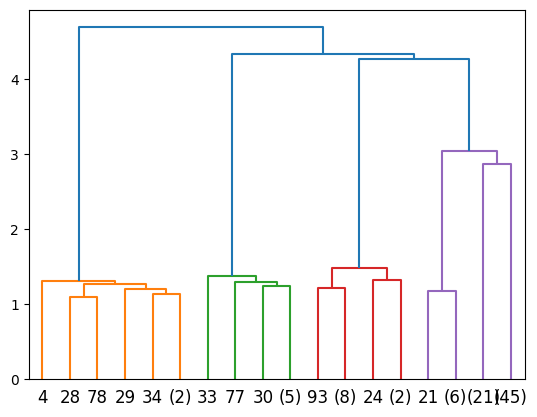

In [71]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=4, truncate_mode='level')

In [72]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)?

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [73]:
bondTFVects

<634x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55731 stored elements in Compressed Sparse Row format>

In [74]:
bondCoocMat = bondTFVects * exampleTFVects.T
bondCoocMat.setdiag(0)
bondlinkage_matrix = scipy.cluster.hierarchy.ward(bondCoocMat[:100, :100].toarray())

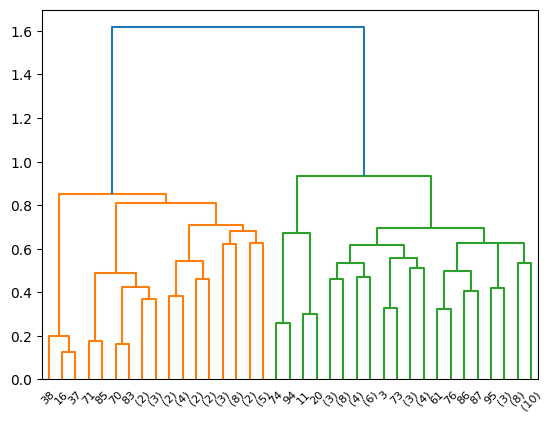

In [75]:
ax = scipy.cluster.hierarchy.dendrogram(bondlinkage_matrix, p=5, truncate_mode='level')

In [76]:
bond_linkage_matrix_full = scipy.cluster.hierarchy.ward(bondCoocMat.toarray())
bond_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(bond_linkage_matrix_full, 4, 'maxclust')

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](https://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

Here again we make use of `lucem_illud` functions. The source code of both of these is in [processing.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/processing.py).

In [77]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [78]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, d, c, today, ..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, d, c, senator..."


In [79]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [80]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [81]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [82]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [83]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [84]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(9, 0.97182953)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [85]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [86]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(8, 0.9725513)]",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.972551,0.000000
101,02Feb2007Kennedy10.txt,"[(2, 0.74055016), (4, 0.25492352)]",0.0,0.000000,0.740550,0.000000,0.254924,0.000000,0.000000,0.0,0.000000,0.000000
201,04May2006Kennedy8.txt,"[(1, 0.0343779), (5, 0.96355706)]",0.0,0.034378,0.000000,0.000000,0.000000,0.963557,0.000000,0.0,0.000000,0.000000
301,06Jun2007Kennedy1.txt,"[(1, 0.7394811), (6, 0.022128442), (8, 0.23510...",0.0,0.739481,0.000000,0.000000,0.000000,0.000000,0.022128,0.0,0.235103,0.000000
401,08Feb2005Kennedy0.txt,"[(2, 0.8963229), (9, 0.09789695)]",0.0,0.000000,0.896323,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.097897
501,09Nov2005Kennedy11.txt,"[(6, 0.9560872)]",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.956087,0.0,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(2, 0.6131697), (3, 0.3619429)]",0.0,0.000000,0.613170,0.361943,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
701,13Jun2006Kennedy1.txt,"[(4, 0.45771816), (6, 0.5397279)]",0.0,0.000000,0.000000,0.000000,0.457718,0.000000,0.539728,0.0,0.000000,0.000000
801,15Dec2005Kennedy5.txt,"[(2, 0.3698864), (3, 0.046754543), (9, 0.58198...",0.0,0.000000,0.369886,0.046755,0.000000,0.000000,0.000000,0.0,0.000000,0.581986
901,16May2007Kennedy5.txt,"[(9, 0.9557439)]",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.955744


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [87]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.97183
1,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.972551,0.00000
2,0.000000,0.0,0.0000,0.000000,0.993657,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.000000,0.0,0.0000,0.000000,0.000000,0.993804,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.0,0.0000,0.997515,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5,0.000000,0.0,0.0000,0.991542,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
6,0.000000,0.0,0.0000,0.000000,0.000000,0.114177,0.000000,0.000000,0.876552,0.00000
7,0.000000,0.0,0.6999,0.000000,0.000000,0.000000,0.000000,0.271683,0.000000,0.00000
8,0.103208,0.0,0.0000,0.000000,0.000000,0.000000,0.835785,0.000000,0.057456,0.00000
9,0.967866,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


First we can visualize as a stacked bar chart:

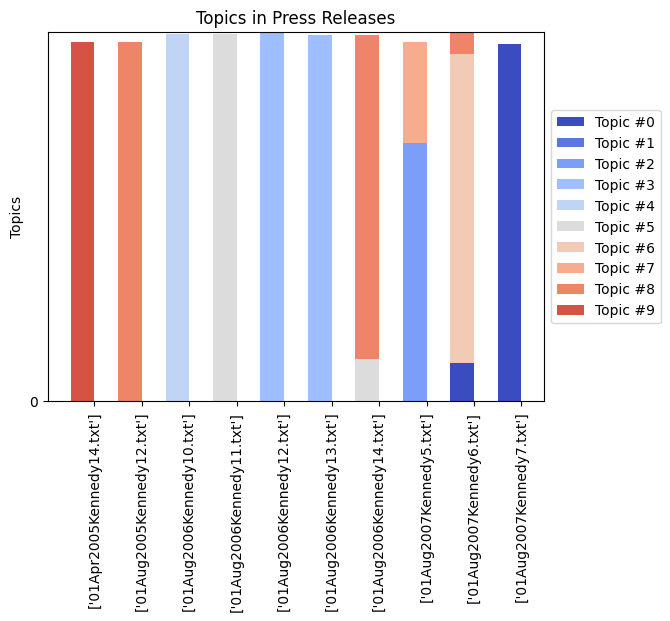

In [88]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

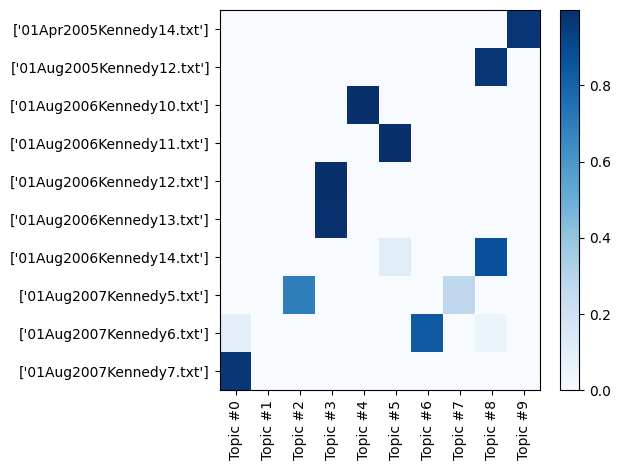

In [89]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [90]:
senlda.show_topic(1)

[('head', 0.005321254),
 ('immigration', 0.0036035758),
 ('teachers', 0.003203974),
 ('intelligence', 0.0025983625),
 ('stem', 0.0025306356),
 ('cell', 0.0024023752),
 ('loan', 0.0022008705),
 ('pension', 0.0021081641),
 ('red', 0.0020536578),
 ('minimum', 0.0017598213)]

And if we want to make a dataFrame:

In [91]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,loan,head,mental,wage,pension,insurance,immigration,asbestos,head,medicare
1,head,immigration,coverage,minimum,loan,bankruptcy,fda,victims,immigrants,immigration
2,victims,teachers,loan,head,iraqi,cases,loan,violence,judge,tax
3,loans,intelligence,insurance,science,fund,minimum,immigrants,retirement,immigration,minimum
4,asbestos,stem,medicare,development,medicaid,fda,insurance,chip,loan,medicaid
5,lenders,cell,association,hour,lenders,patients,loans,fund,coverage,wage
6,fund,loan,tobacco,teachers,victims,dr,minimum,trust,insurance,seniors
7,liheap,pension,patients,immigration,compensation,medicare,border,cases,association,cuts
8,trust,red,cuts,raising,trust,stem,drugs,coverage,medicare,sick
9,lender,minimum,iraqi,insurance,disaster,coverage,wage,immigration,lenders,coverage


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 640x480 with 0 Axes>

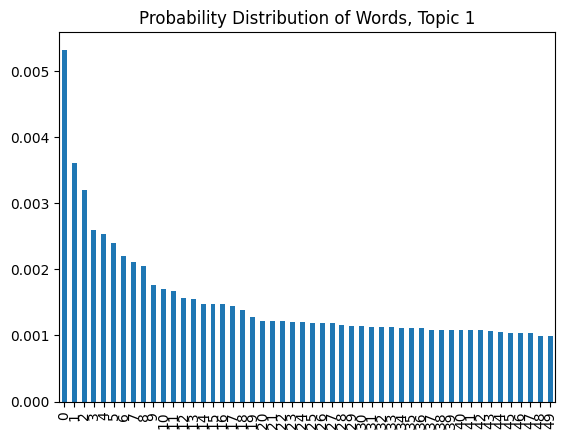

In [92]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [93]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

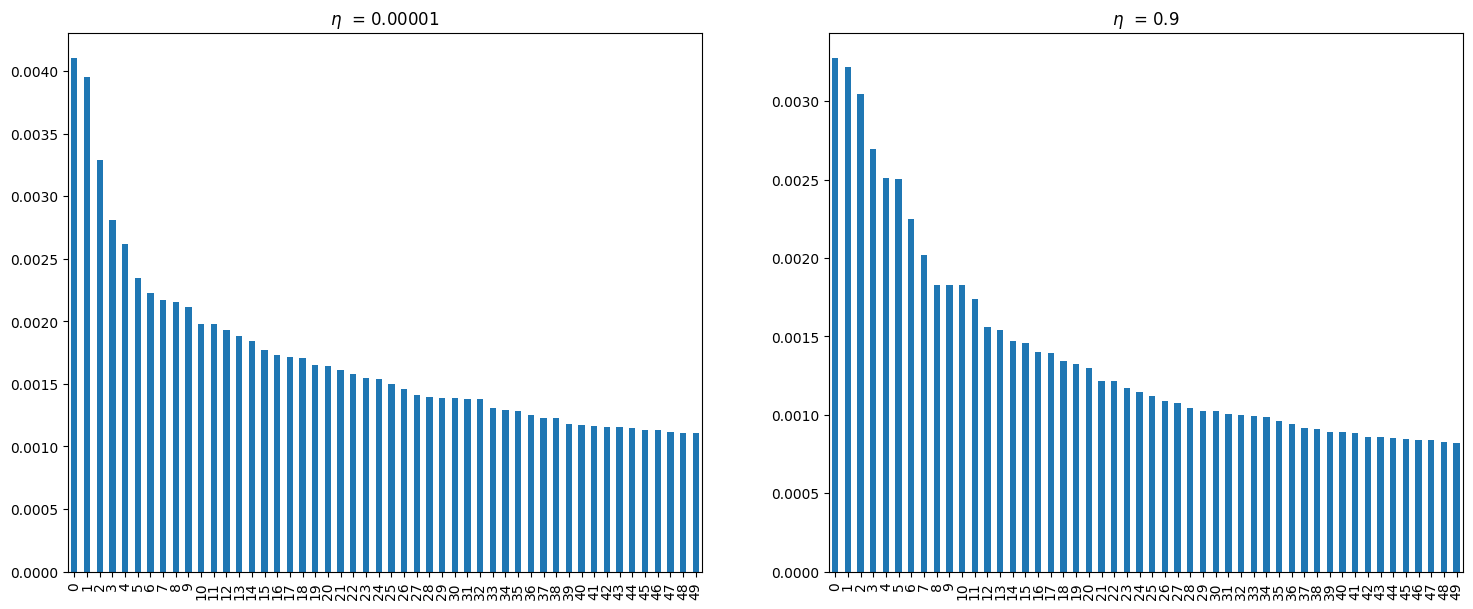

In [94]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

### Heirarchial Dirichlet Process

We use LDA topic modeling above, but a similar alternative model you may run across is Hierarchical Dirichlet Processes, a nonparametric generalization of LDA. See, for example, [Teodoridis et al 2020](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3596233). One difference is how the researcher selects the number of topics.

In [95]:
from gensim.models import HdpModel

In [96]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [97]:
hdpmodel.print_topics()

[(0,
  '0.004*head + 0.003*loan + 0.003*wage + 0.002*minimum + 0.002*teachers + 0.002*insurance + 0.002*immigration + 0.002*coverage + 0.002*tobacco + 0.002*aid'),
 (1,
  '0.010*asbestos + 0.007*victims + 0.006*fund + 0.006*trust + 0.004*compensation + 0.004*iraqi + 0.003*violence + 0.003*lung + 0.003*claims + 0.003*exposure'),
 (2,
  '0.007*association + 0.004*immigration + 0.003*mental + 0.003*immigrants + 0.002*insurance + 0.002*title + 0.002*coverage + 0.002*psychological + 0.002*english + 0.002*small'),
 (3,
  '0.010*loan + 0.006*loans + 0.006*lenders + 0.005*lender + 0.003*colleges + 0.003*preferred + 0.002*aid + 0.002*gulf + 0.002*lists + 0.002*heating'),
 (4,
  '0.005*judge + 0.004*myers + 0.003*boyle + 0.003*circuit + 0.002*attorney + 0.002*brain + 0.002*native + 0.002*tribe + 0.002*tbi + 0.002*title'),
 (5,
  '0.006*cuts + 0.005*head + 0.003*tax + 0.002*medicaid + 0.002*presidents + 0.002*insurance + 0.002*medicare + 0.002*global + 0.002*math + 0.002*science'),
 (6,
  '0.005*

Gensim sets the default number of topics as 150. This [stack overflow link](https://stackoverflow.com/questions/31543542/hierarchical-dirichlet-process-gensim-topic-number-independent-of-corpus-size) walks you through how to truncate these topics.

In [98]:
hdptexts = hdpmodel[corpus]

In [99]:
hdptexts[0]

[(0, 0.36768911677429555), (114, 0.6168507059693507)]

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font>

This [HDP tutorial](https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a) walks us through alternative HDP implementations outside of gensim.

In [100]:
#Apply our functions
sen_ex1['tokenized_text'] =sen_ex1['text'].apply(lambda x: lucem_illud.word_tokenize(x))
sen_ex1['normalized_tokens'] = sen_ex1['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [101]:
sen_ex1[::100]

,Unnamed: 0,name,text,path,html_url,download_url,targetSenatorex1,kmeans_predictions,tokenized_text,normalized_tokens
0,0,10Aug2005Bond136.txt,"\nWASHINGTON, DC – As chairman of the Senate T...",raw/Bond/10Aug2005Bond136.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,1,"[WASHINGTON, DC, As, chairman, of, the, Senate...","[washington, dc, chairman, senate, transportat..."
100,100,14Nov2007Bond210.txt,"\n(Washington, D.C.) Today, the United States...",raw/Bond/14Nov2007Bond210.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,1,"[Washington, D.C., Today, the, United, States,...","[washington, d.c, today, united, states, senat..."
200,200,1Apr2005Bond40.txt,"\n\tST. LOUIS, MO - U.S. Senator Kit Bond toda...",raw/Bond/1Apr2005Bond40.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,0,"[ST, LOUIS, MO, U.S., Senator, Kit, Bond, toda...","[st, louis, mo, u.s, senator, kit, bond, today..."
300,300,22Jun2007Bond97.txt,"\nWASHINGTON, DC - U.S. Senator Kit Bond today...",raw/Bond/22Jun2007Bond97.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,0,"[WASHINGTON, DC, U.S., Senator, Kit, Bond, tod...","[washington, dc, u.s, senator, kit, bond, toda..."
400,400,28Jul2005Bond116.txt,\nWith negotiators reaching an agreement on a ...,raw/Bond/28Jul2005Bond116.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,1,"[With, negotiators, reaching, an, agreement, o...","[negotiators, reaching, agreement, new, transp..."
500,500,31Mar2006Bond38.txt,"\nST. LOUIS, MO – U.S. Senator Kit Bond today ...",raw/Bond/31Mar2006Bond38.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,1,"[ST, LOUIS, MO, U.S., Senator, Kit, Bond, toda...","[st, louis, mo, u.s, senator, kit, bond, today..."
600,600,7Sep2006Bond129.txt,"\nWASHINGTON, DC – U.S. Senators Kit Bond and ...",raw/Bond/7Sep2006Bond129.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Bond,1,"[WASHINGTON, DC, U.S., Senators, Kit, Bond, an...","[washington, dc, u.s, senators, kit, bond, jim..."


In [102]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]
sen_ex1['reduced_tokens'] = sen_ex1['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [103]:
dictionary = gensim.corpora.Dictionary(sen_ex1['reduced_tokens'])

In [104]:
corpus = [dictionary.doc2bow(text) for text in sen_ex1['reduced_tokens']]

In [105]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

In [106]:
senldabond = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [107]:
sen1Bowbond = dictionary.doc2bow(sen_ex1['reduced_tokens'][0])
sen1ldabond = senldabond[sen1Bowbond]
print("The topics of the text: {}".format(sen_ex1['name'][0]))
print("are: {}".format(sen1ldabond))

The topics of the text: 10Aug2005Bond136.txt
are: [(1, 0.96505874), (7, 0.024173582)]


In [108]:
ldabondDF = pandas.DataFrame({
        'name' : sen_ex1['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in sen_ex1['reduced_tokens']]
    })

In [109]:
print(len(ldabondDF))

634


In [110]:
# Dict to temporally hold the probabilities
topicsProbDictbond = {i: [0] * len(ldabondDF) for i in range(senldabond.num_topics)}

# Load them into the dict
for index, topicTuples in enumerate(ldabondDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDictbond[topicNum][index] = prob

# Update the DataFrame
for topicNum in range(senldabond.num_topics):
    # Check topicsProbDictbond[topicNum] length and trim or fill to match ldabondDF length
    ldabondDF['topic_{}'.format(topicNum)] = topicsProbDictbond[topicNum][:len(ldabondDF)]
    # If lengths are not equal, you can also fill the missing part, for example:
    # ldabondDF['topic_{}'.format(topicNum)] = topicsProbDictbond[topicNum] + [0] * (len(ldabondDF) - len(topicsProbDictbond[topicNum]))

ldabondDF[1::100]


,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,10Aug2005Bond137.txt,"[(3, 0.50328153), (8, 0.34291652), (9, 0.14287...",0.000000,0.000000,0.0,0.503282,0.0,0.000000,0.000000,0.0,0.342917,0.142878
101,14Nov2007Bond211.txt,"[(0, 0.047909807), (3, 0.17275555), (6, 0.4512...",0.047910,0.000000,0.0,0.172756,0.0,0.000000,0.451209,0.0,0.319621,0.000000
201,1Dec2005Bond197.txt,"[(0, 0.12563777), (3, 0.17441596), (5, 0.18488...",0.125638,0.000000,0.0,0.174416,0.0,0.184890,0.445527,0.0,0.063725,0.000000
301,22Jun2007Bond98.txt,"[(3, 0.0870402), (5, 0.031816427), (6, 0.22800...",0.000000,0.000000,0.0,0.087040,0.0,0.031816,0.228004,0.0,0.564751,0.083048
401,28Jul2005Bond117.txt,"[(3, 0.28883088), (5, 0.059828702), (6, 0.1097...",0.000000,0.000000,0.0,0.288831,0.0,0.059829,0.109750,0.0,0.535294,0.000000
501,31May2005Bond81.txt,"[(0, 0.121389836), (3, 0.036849983), (5, 0.138...",0.121390,0.000000,0.0,0.036850,0.0,0.138144,0.552312,0.0,0.000000,0.140623
601,8Dec2006Bond183.txt,"[(1, 0.09048238), (3, 0.34228536), (5, 0.34772...",0.000000,0.090482,0.0,0.342285,0.0,0.347730,0.196455,0.0,0.018695,0.000000


In [111]:
ldabondDFV = ldabondDF[:10][['topic_%d' %x for x in range(10)]]
ldabondDFVisN = ldabondDF[:10][['name']]
ldabondDFVis = ldabondDFV.values
ldabondDFVisNames = ldabondDFVisN.values
ldabondDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.0,0.0,0.0,0.581207,0.000000,0.000000,0.000000,0.0,0.278970,0.128627
1,0.0,0.0,0.0,0.503282,0.000000,0.000000,0.000000,0.0,0.342917,0.142878
2,0.0,0.0,0.0,0.196258,0.259080,0.000000,0.000000,0.0,0.536207,0.000000
3,0.0,0.0,0.0,0.000000,0.752665,0.236916,0.000000,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.231992,0.000000,0.474221,0.000000,0.0,0.287113,0.000000
5,0.0,0.0,0.0,0.178974,0.178675,0.632163,0.000000,0.0,0.000000,0.000000
6,0.0,0.0,0.0,0.373178,0.000000,0.317913,0.247694,0.0,0.054485,0.000000
7,0.0,0.0,0.0,0.310163,0.000000,0.179873,0.094732,0.0,0.406982,0.000000
8,0.0,0.0,0.0,0.992661,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,0.0,0.0,0.0,0.908625,0.000000,0.000000,0.081654,0.0,0.000000,0.000000


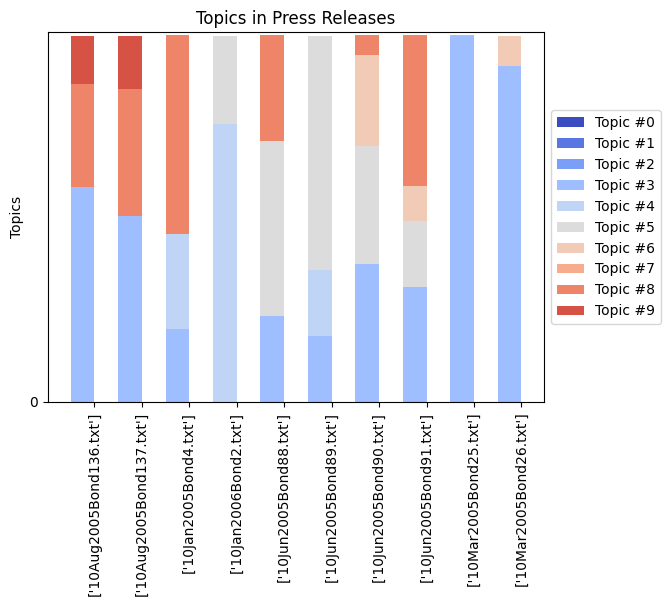

In [112]:
N = 10
ind = np.arange(N)
K = senldabond.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldabondDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldabondDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldabondDFVis[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldabondDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

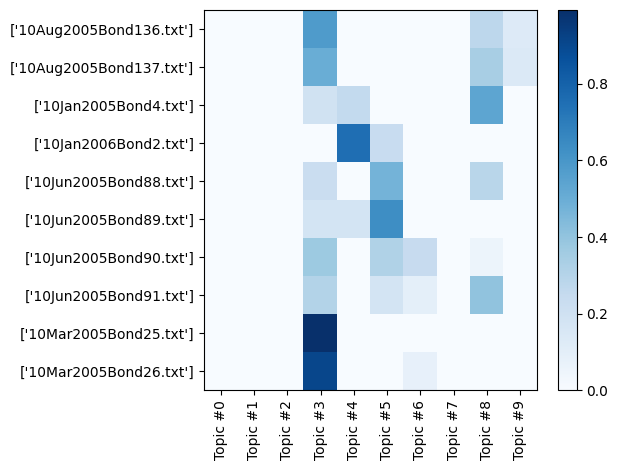

In [113]:
plt.pcolor(ldabondDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldabondDFVis.shape[0])+0.5, ldabondDFVisNames);
plt.xticks(np.arange(ldabondDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [114]:
senlda.show_topic(1)

[('head', 0.005321254),
 ('immigration', 0.0036035758),
 ('teachers', 0.003203974),
 ('intelligence', 0.0025983625),
 ('stem', 0.0025306356),
 ('cell', 0.0024023752),
 ('loan', 0.0022008705),
 ('pension', 0.0021081641),
 ('red', 0.0020536578),
 ('minimum', 0.0017598213)]

In [115]:
topicsDictbond = {}
for topicNumbond in range(senlda.num_topics):
    topicWordsbond = [w for w, p in senlda.show_topic(topicNumbond)]
    topicsDictbond['Topic_{}'.format(topicNumbond)] = topicWordsbond

wordRanksbondDF = pandas.DataFrame(topicsDictbond)
wordRanksbondDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,loan,head,mental,wage,pension,insurance,immigration,asbestos,head,medicare
1,head,immigration,coverage,minimum,loan,bankruptcy,fda,victims,immigrants,immigration
2,victims,teachers,loan,head,iraqi,cases,loan,violence,judge,tax
3,loans,intelligence,insurance,science,fund,minimum,immigrants,retirement,immigration,minimum
4,asbestos,stem,medicare,development,medicaid,fda,insurance,chip,loan,medicaid
5,lenders,cell,association,hour,lenders,patients,loans,fund,coverage,wage
6,fund,loan,tobacco,teachers,victims,dr,minimum,trust,insurance,seniors
7,liheap,pension,patients,immigration,compensation,medicare,border,cases,association,cuts
8,trust,red,cuts,raising,trust,stem,drugs,coverage,medicare,sick
9,lender,minimum,iraqi,insurance,disaster,coverage,wage,immigration,lenders,coverage


<Figure size 640x480 with 0 Axes>

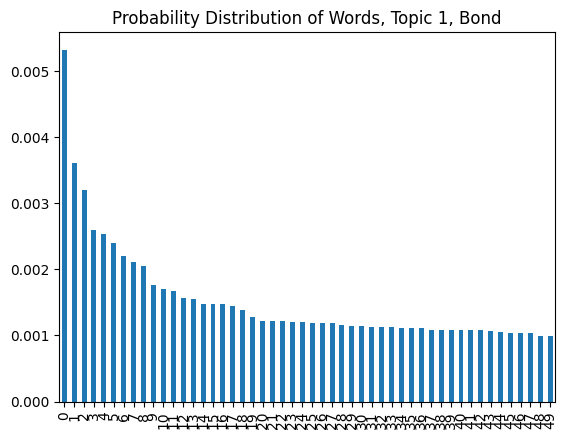

In [116]:
topic1_dfbond = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1, Bond')
plt.show()

In [117]:
senldabond1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senldabond2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

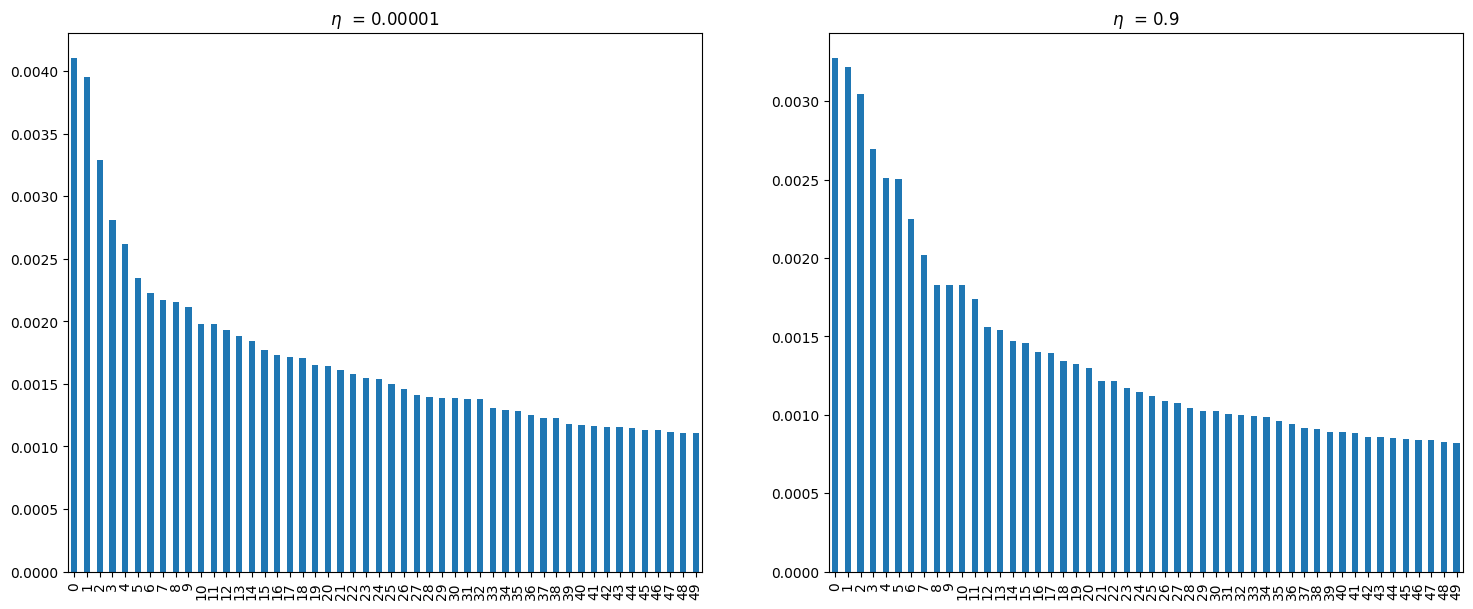

In [118]:
topic11_dfbond = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_dfbond = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

In [119]:
from gensim.models import HdpModel

In [120]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [121]:
hdpmodel.print_topics(5)

[(0,
  '0.033*bond + 0.018*missouri + 0.008*transportation + 0.008*secured + 0.006*projects + 0.006*st + 0.006*city + 0.005*includes + 0.005*highway + 0.005*reduction'),
 (1,
  '0.032*bond + 0.012*missouri + 0.006*transportation + 0.005*intelligence + 0.005*kit + 0.004*city + 0.003*development + 0.003*stressed + 0.003*st + 0.003*secured'),
 (2,
  '0.021*bond + 0.011*missouri + 0.005*st + 0.004*kit + 0.003*transportation + 0.003*river + 0.003*water + 0.003*talent + 0.003*secured + 0.003*city'),
 (3,
  '0.015*bond + 0.004*energy + 0.004*missouri + 0.004*city + 0.003*st + 0.003*kit + 0.002*intelligence + 0.002*crime + 0.002*guard + 0.002*fuel'),
 (4,
  '0.012*bond + 0.007*missouri + 0.004*biotechnology + 0.003*located + 0.003*company + 0.003*small + 0.002*st + 0.002*university + 0.002*talent + 0.002*development')]

In [122]:
hdptexts = hdpmodel[corpus]

In [123]:
hdptexts[0]

[(0, 0.9160455877365422), (11, 0.07313339805119695)]

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does. `lucem_illud.loadDavies` can be found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py).

In [124]:
corpora_address = "/content/drive/MyDrive/SOCI40133/SOAP"


In [125]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=200)

text_0-tez.zip
text_1-teh.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_5-rag.zip
text_6-egn.zip
text_7-jss.zip
text_8-sbo.zip
text_9-jtw.zip


In [126]:
import zipfile
import pandas as pd

In [127]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [128]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [129]:
soap_dict = {}

In [130]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [131]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [132]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [133]:
i = 0

In [134]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [135]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Liza, You, 're, in, early, @!Ryan, Yeah, I,..."
1,As the World Turns,"[@!Katie, Simon, where, are, you, @!Simon, Kat..."
2,Bold and Beautiful,"[@!Morgan, What, 's, the, matter, Stephanie, Y..."
3,Days of Our Lives,"[@!Philip, Seems, like, every, time, I, look, ..."
4,General Hospital,"[@!Stefan, I, love, her, @!Jax, No, Cassadine,..."
5,Guiding Light,"[@!Reva, Well, it, 's, very, peaceful, Your, b..."
6,One Life to Live,"[@!Rae, What, She, even, has, a, new, friend, ..."
7,Passions,"[@!Kay, Going, to, get, pregnant, and, I, 'm, ..."
8,Port Charles,"[@!Jack, There, you, are, you, son, @!Chris, H..."
9,Young and Restless,"[@!Sharon, Yeah, I, could, n't, sleep, @!Victo..."


Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [136]:
dool = soap_df['Tokenized Texts'][9]

In [137]:
' '.join(dool[0:1500])

"@!Sharon Yeah I could n't sleep @!Victoria Nightmares @!Sharon Vicki thank you for spending the night @!Victoria Of course I would n't leave you and the kids alone You want to talk about it @!Sharon I do n't think I can @!Victoria It might help to get it out @!Sharon You know the worst part is n't when Matt Clark attacked me It was when he made me stare into his eyes He had this old picture of the way he used to look And I kept going from the picture to his face And then it was like like a horror movie or something I could n't breathe I felt like I was back in that car again @!Victoria Sharon there is nothing I can do or say to take the pain away I want you to know they will find him and you will never ever have to worry about Matt Clark ever again @!Nikki Hi You all right @!Victoria Any word on Matt Clark @!Nikki No they have him The police have helicopters They have search dogs @!Victor Apparently he left by car @!Sharon What car @!Victor Another set of tire marks were found near th

In [138]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [139]:
import networkx as nx

In [140]:
actor_network = nx.Graph()

In [141]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [142]:
i = 0

In [143]:
all_texts = []

In [144]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


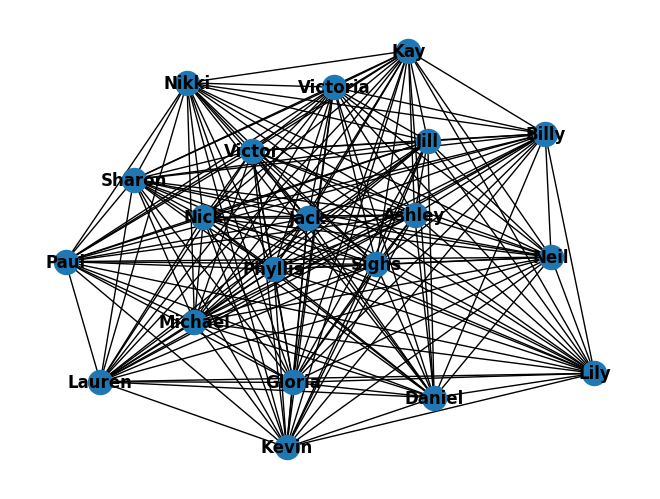

In [145]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [146]:
all_texts[0:10]

[['yeah', 'sleep'],
 ['nightmares'],
 ['vicki', 'thank', 'spending', 'night'],
 ['course', 'leave', 'kids', 'want', 'talk'],
 ['think'],
 ['help'],
 ['know',
  'worst',
  'matt',
  'clark',
  'attacked',
  'stare',
  'eyes',
  'old',
  'picture',
  'way',
  'look',
  'kept',
  'going',
  'picture',
  'face',
  'like',
  'like',
  'horror',
  'movie',
  'breathe',
  'felt',
  'like',
  'car'],
 ['sharon', 'pain', 'away', 'want', 'know', 'find', 'worry', 'matt', 'clark'],
 ['hi', 'right'],
 ['word', 'matt', 'clark']]

In [147]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [148]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [149]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [150]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [151]:
doollda.show_topics()

[(0,
  '0.109*"to" + 0.095*"go" + 0.068*"m" + 0.067*"right" + 0.037*"got" + 0.024*"love" + 0.024*"need" + 0.020*"sharon" + 0.016*"nick" + 0.014*"baby"'),
 (1,
  '0.029*"believe" + 0.028*"going" + 0.028*"phone" + 0.022*"jail" + 0.020*"cell" + 0.019*"find" + 0.018*"saw" + 0.018*"victoria" + 0.017*"lily" + 0.016*"house"'),
 (2,
  '0.052*"yes" + 0.050*"think" + 0.038*"said" + 0.033*"talk" + 0.033*"know" + 0.028*"care" + 0.025*"want" + 0.022*"hear" + 0.022*"mind" + 0.021*"daisy"'),
 (3,
  '0.135*"know" + 0.052*"good" + 0.043*"like" + 0.039*"time" + 0.030*"ve" + 0.018*"think" + 0.015*"feel" + 0.015*"better" + 0.015*"billy" + 0.014*"things"'),
 (4,
  '0.103*"uh" + 0.063*"hey" + 0.034*"tell" + 0.034*"adam" + 0.031*"victor" + 0.030*"maybe" + 0.021*"know" + 0.018*"michael" + 0.016*"tucker" + 0.016*"huh"'),
 (5,
  '0.036*"let" + 0.028*"understand" + 0.026*"talking" + 0.021*"happened" + 0.019*"deal" + 0.017*"mom" + 0.017*"reason" + 0.016*"wo" + 0.016*"today" + 0.016*"big"'),
 (6,
  '0.141*"okay" +

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [152]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about.

In [153]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Sharon [(0, 0.0605202), (1, 0.022007883), (3, 0.045126118), (4, 0.2313281), (6, 0.112199575), (7, 0.050677713), (8, 0.19182935), (9, 0.28630918)]
Victoria [(0, 0.059443515), (1, 0.023542501), (3, 0.04267788), (4, 0.2284001), (6, 0.113474704), (7, 0.05387562), (8, 0.1937156), (9, 0.28486744)]
Nikki [(0, 0.058385868), (1, 0.022664508), (3, 0.04203449), (4, 0.23220585), (6, 0.11078969), (7, 0.050616935), (8, 0.19600125), (9, 0.2872993)]
Victor [(0, 0.062261265), (1, 0.02257855), (3, 0.041280665), (4, 0.22751647), (6, 0.11162788), (7, 0.048768576), (8, 0.19686498), (9, 0.2890999)]
Billy [(0, 0.06587165), (1, 0.021731066), (3, 0.04312178), (4, 0.22695473), (6, 0.11181741), (7, 0.048592396), (8, 0.19205883), (9, 0.28984827)]
Phyllis [(0, 0.06485428), (1, 0.020188494), (3, 0.04244094), (4, 0.23421578), (6, 0.114169426), (7, 0.050440665), (8, 0.18751754), (9, 0.28617126)]
Jack [(0, 0.0585499), (1, 0.02260789), (3, 0.04232503), (4, 0.2292663), (6, 0.106051706), (7, 0.047204264), (8, 0.19746085)

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally.

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [154]:
from gensim.matutils import kullback_leibler

In [155]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [156]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution']
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution']
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

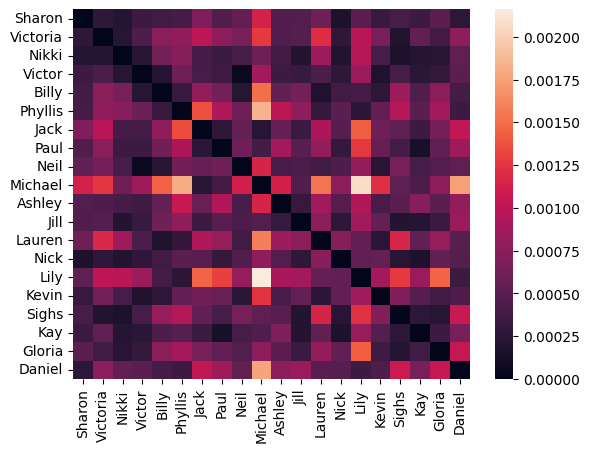

In [157]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/.


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about.

(An acknowledgement - Bhargav (the author of most of this class's code) wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [158]:
corpora_address = "/content/drive/MyDrive/SOCI40133/COHA"

In [159]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

text_1810s_kso.zip
text_1820s_jsi.zip
text_1830s_bsu.zip
text_1840s_nsq.zip
text_1850s_jpr.zip
text_1860s_psi.zip
text_1870s_vuy.zip
text_1880s_azz.zip
text_1890s_jsq.zip
text_1900s_mse.zip
text_1910s_jue.zip
text_1920s_gte.zip
text_1930s_bie.zip
text_1940s_bsw.zip
text_1950s_ndz.zip
text_1960s_xus.zip
text_1970s_jfy.zip
text_1980s_bkk.zip
text_1990s_bsj.zip
text_2000s_scc.zip


In [160]:
list(coha_texts.keys())[0:5]

['mag_1815_552651.txt',
 'mag_1816_552727.txt',
 'mag_1816_552728.txt',
 'mag_1816_552807.txt',
 'mag_1816_552808.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts, and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [1]:
coha_genres = {}
coha_years = {}

In [161]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])

    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])

In [162]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [163]:
coha_years.keys()

dict_keys(['1815', '1816', '1817', '1818', '1819', '1810', '1811', '1812', '1813', '1814', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1830', '1831', '1832', '1833', '1834', '1835', '1836', '1837', '1838', '1839', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857', '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [164]:
import collections

In [165]:
years = []
year_lens = []

In [166]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [167]:
years[0], years[-1]

('1810', '2009')

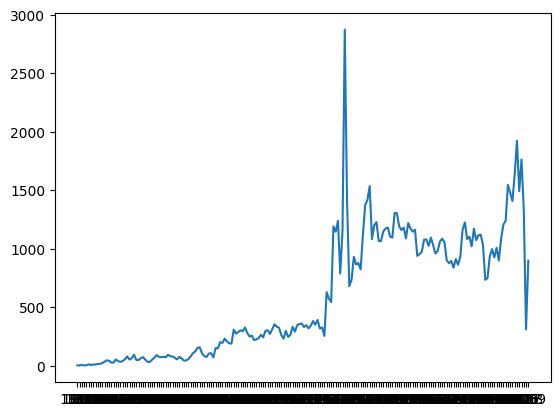

In [168]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [169]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [170]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the
    if i < 70:
        docs_per_timeslice[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_timeslice[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_timeslice[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_timeslice[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_timeslice[4] += len(coha_years[year_info]) - large_files
    i += 1

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


KeyboardInterrupt: 

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [171]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [172]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [173]:
small_corpus = choose_n(all_texts_coha, docs_per_timeslice, nums=100)

In [174]:
final_corpus= []

In [175]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice.

In [176]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4

    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [177]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [178]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [179]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [180]:
from gensim.models import ldaseqmodel

In [182]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

KeyboardInterrupt: 

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")

For future research, you can also consider the Structural Topic Model (STM), which can integrate any covariates (e.g., time, author, document length) into your topic model. Unfortunately there is not yet an implementation of this in Python, but there is a wonderful [R package](https://www.structuraltopicmodel.com/) authored by Molly Roberts, Brandon Stewart, and Dustin Tingley.

Here are plate diagrams of LDA and STM, which may help you visualize the way STM adds covariates to the "left" and "right" of the standard LDA model.

<img src="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-3/img/lda_stm_plate_diagrams.jpg" alt="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-3/img/lda_stm_plate_diagrams.jpg" style="width:500px">



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [183]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Liza, You, 're, in, early, @!Ryan, Yeah, I,..."
1,As the World Turns,"[@!Katie, Simon, where, are, you, @!Simon, Kat..."
2,Bold and Beautiful,"[@!Morgan, What, 's, the, matter, Stephanie, Y..."
3,Days of Our Lives,"[@!Philip, Seems, like, every, time, I, look, ..."
4,General Hospital,"[@!Stefan, I, love, her, @!Jax, No, Cassadine,..."
5,Guiding Light,"[@!Reva, Well, it, 's, very, peaceful, Your, b..."
6,One Life to Live,"[@!Rae, What, She, even, has, a, new, friend, ..."
7,Passions,"[@!Kay, Going, to, get, pregnant, and, I, 'm, ..."
8,Port Charles,"[@!Jack, There, you, are, you, son, @!Chris, H..."
9,Young and Restless,"[@!Sharon, Yeah, I, could, n't, sleep, @!Victo..."


In [184]:
dool6 = soap_df['Tokenized Texts'][6]

In [185]:
' '.join(dool6[0:1500])

"@!Rae What She even has a new friend somebody she likes and she trusts @!Ben Ok that 's not why you decided she 's ready to leave @!Rae No no @!Ben No @!Rae Ben come on She is ready @!Ben Ok so we 're all just supposed to sign off on that huh @!Rae You know Viki has forgiven her I do n't know why you ca n't @!Ben Well maybe Viki 's a nicer person than I am especially when it comes to Allison Perkins @!Hank Hey Excuse me @!Rae Hank @!Hank Rae I 'm going to be late for John 's party but tell him I will be there @!Rae My God look what time it is @!Hank Yeah I 'm stuck here trying to get a competency hearing scheduled for a suspect they just checked in @!Rae Well if I do n't leave right now I 'm going to really be late so I 'll see you there @!Ben Ok wait any idea where Allison went @!Rae No And you know what Even if I did I would n't tell you @!Ben Thanks a lot @!Rae She has the right to her own privacy Ben And soon she will have earned the right to her own freedom @!Ben Freedom Freedom 

In [186]:
characters6 = {}
for token in dool6:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters6:
            characters6[token[2:]] = 0
        if token[2:] in characters6:
            characters6[token[2:]] += 1

In [187]:
import networkx as nx

In [188]:
actor_network6 = nx.Graph()

In [189]:
for character in characters6:
    if characters6[character] > 2000:
        actor_network6.add_node(character, lines_spoken= characters6[character], words=[])

In [190]:
i = 0

In [191]:
all_texts6 = []

In [192]:
for token in dool6:
    i += 1
    if i > len(dool6):
        break
    if token[0] == "@":
        if token[2:] in actor_network6.nodes():
            j = i
            for token_ in dool6[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network6.nodes():
                        if (token[2:], token_[2:]) not in actor_network6.edges():
                            actor_network6.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network6.edges():
                            actor_network6.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network6.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts6.append(lucem_illud.normalizeTokens(dool[i:j]))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


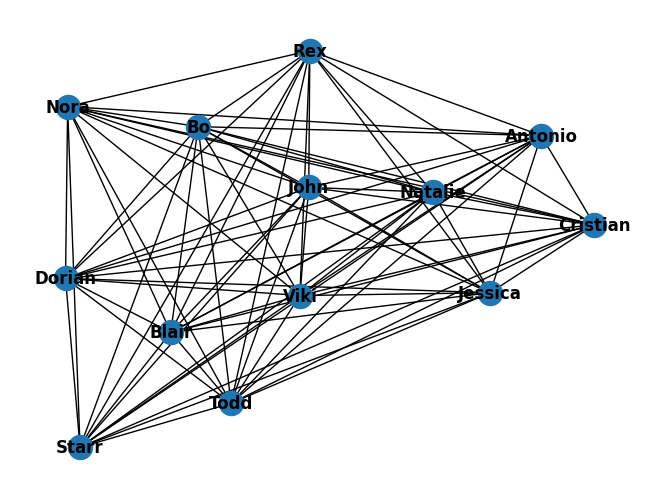

In [193]:
nx.draw(actor_network6, with_labels=True, font_weight='bold')

In [194]:
all_texts6[0:10]

[['life', 'line', 'coming', 'home', 'day', '@!victoria'],
 ['found',
  'police',
  'helicopters',
  'search',
  'dogs',
  '@!victoria',
  'apparently'],
 ['happening', 'got', 'away'],
 ['mr',
  'newman',
  '@!nicholas',
  'word',
  'father',
  '@!guard',
  'look',
  'newman',
  'favor'],
 ['understand', '@!guard'],
 ['special', 'privileges', '@!nicholas', 'need'],
 ['@!j.t'],
 ['depressing'],
 ['bad', '@!j.t', 'hate', 'going', 'swing', 'check', 'want', 'come'],
 ['play',
  'tough',
  'bothering',
  '@!j.t',
  'says',
  '@!mack',
  'look',
  'j.t',
  'friend',
  'want',
  'know',
  'wrong',
  'maybe',
  'help',
  '@!billy',
  'brittany',
  '@!brittany',
  'luck',
  'brought',
  'breakfast',
  '@!billy',
  'actually',
  'head',
  'hospital',
  '@!brittany',
  've',
  'got']]

In [195]:
dictionary6 = gensim.corpora.Dictionary(all_texts6)

In [196]:
corpus6 = [dictionary6.doc2bow(text) for text in all_texts6]

In [197]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus6)
doolcorpus6 = gensim.corpora.MmCorpus('dool.mm')

In [198]:
doollda6 = gensim.models.ldamodel.LdaModel(corpus=doolcorpus6, id2word=dictionary6, num_topics=10, alpha='auto', eta='auto')

In [199]:
doollda6.show_topics()

[(0,
  '0.036*"@(chuckles" + 0.035*"@!phyllis" + 0.031*"@!michael" + 0.025*"tell" + 0.020*"going" + 0.018*"let" + 0.018*"oh" + 0.016*"@!gloria" + 0.016*"away" + 0.014*"stop"'),
 (1,
  '0.082*"to" + 0.071*"go" + 0.058*"know" + 0.044*"@!ashley" + 0.035*"m" + 0.031*"okay" + 0.028*"need" + 0.027*"@!neil" + 0.023*"@!abby" + 0.013*"fine"'),
 (2,
  '0.052*"oh" + 0.051*"@!kay" + 0.047*"like" + 0.043*"come" + 0.036*"@!cane" + 0.032*"@!billy" + 0.024*"know" + 0.022*"billy" + 0.020*"way" + 0.016*"look"'),
 (3,
  '0.047*"mm" + 0.039*"think" + 0.039*"hmm" + 0.038*"time" + 0.030*"@!victoria" + 0.024*"thank" + 0.021*"baby" + 0.018*"maybe" + 0.017*"door" + 0.016*"leave"'),
 (4,
  '0.086*"uh" + 0.071*"m" + 0.059*"@!lily" + 0.034*"@!kevin" + 0.025*"sorry" + 0.023*"okay" + 0.023*"@!chloe" + 0.023*"dad" + 0.018*"oh" + 0.017*"little"'),
 (5,
  '0.081*"@(sighs" + 0.075*"yeah" + 0.033*"right" + 0.025*"know" + 0.025*"m" + 0.023*"@(laughs" + 0.022*"@!billy" + 0.021*"hey" + 0.020*"sure" + 0.018*"good"'),
 (6,
 

In [200]:
for actor in actor_network6.nodes():
    actor_all_words6 = []
    for sent in actor_network6.nodes[actor]['words']:
        for word in sent:
            actor_all_words6 += word
    actor_network6.nodes[actor]['topic_distribution'] = doollda6[dictionary6.doc2bow(lucem_illud.normalizeTokens(actor_all_words))]

In [201]:
for actor in actor_network6.nodes():
    print(actor, actor_network6.nodes[actor]['topic_distribution'])

Jessica [(0, 0.06251321), (2, 0.06796753), (4, 0.25586006), (6, 0.1462509), (7, 0.28705323), (9, 0.18034649)]
Natalie [(0, 0.06251321), (2, 0.06796753), (4, 0.25586006), (6, 0.1462509), (7, 0.28705323), (9, 0.18034649)]
Viki [(0, 0.06251321), (2, 0.06796753), (4, 0.2558601), (6, 0.14625087), (7, 0.28705323), (9, 0.18034649)]
Todd [(0, 0.06251321), (2, 0.06796753), (4, 0.2558601), (6, 0.14625087), (7, 0.28705323), (9, 0.18034649)]
John [(0, 0.06251321), (2, 0.06796753), (4, 0.2558601), (6, 0.14625087), (7, 0.28705323), (9, 0.18034649)]
Antonio [(0, 0.06251321), (2, 0.06796753), (4, 0.25586006), (6, 0.1462509), (7, 0.28705323), (9, 0.18034649)]
Bo [(0, 0.06251321), (2, 0.06796753), (4, 0.2558601), (6, 0.14625087), (7, 0.28705323), (9, 0.18034649)]
Blair [(0, 0.06251321), (2, 0.06796753), (4, 0.2558601), (6, 0.14625087), (7, 0.28705323), (9, 0.18034649)]
Nora [(0, 0.06251321), (2, 0.06796753), (4, 0.25586006), (6, 0.1462509), (7, 0.28705323), (9, 0.18034649)]
Cristian [(0, 0.06251321), (2

In [202]:
from gensim.matutils import kullback_leibler

In [203]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [204]:
L = []
for actor_1 in actor_network6.nodes():
    p = actor_network6.nodes[actor_1]['topic_distribution']
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network6.nodes():
        q = actor_network6.nodes[actor_2]['topic_distribution']
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

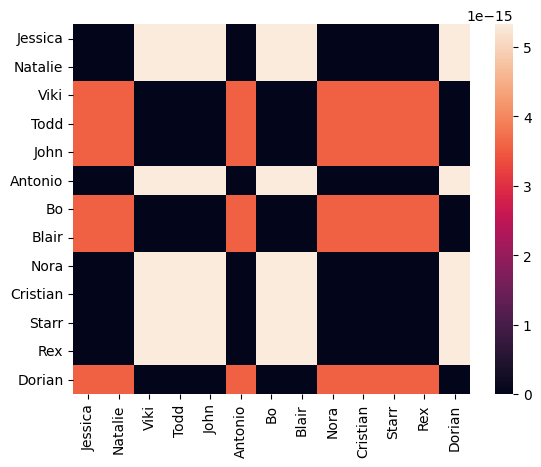

In [205]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network6.nodes()), index = list(actor_network6.nodes()))
ax = sns.heatmap(div)
plt.show()

In [206]:
corpora_addressex4 = "/content/drive/MyDrive/SOCI40133/COHA"
coha_textsex4 = lucem_illud.loadDavies(corpora_addressex4, return_raw=True)

text_1810s_kso.zip
text_1820s_jsi.zip
text_1830s_bsu.zip
text_1840s_nsq.zip
text_1850s_jpr.zip
text_1860s_psi.zip
text_1870s_vuy.zip
text_1880s_azz.zip
text_1890s_jsq.zip
text_1900s_mse.zip
text_1910s_jue.zip
text_1920s_gte.zip
text_1930s_bie.zip
text_1940s_bsw.zip
text_1950s_ndz.zip
text_1960s_xus.zip
text_1970s_jfy.zip
text_1980s_bkk.zip
text_1990s_bsj.zip
text_2000s_scc.zip


In [207]:
coha_genresex4 = {}
coha_yearseex4 = {}


In [208]:
for article in coha_textsex4:
    genre, year, _ = article.split("_")
    if genre not in coha_genresex4:
        coha_genresex4[genre] = []
    coha_genresex4[genre].append(coha_textsex4[article])
    if year not in coha_yearseex4:
        coha_yearseex4[year] = []
    coha_yearseex4[year].append(coha_textsex4[article])


In [209]:
years = []
year_lens = []
for year_info in sorted(coha_yearseex4 .keys()):
    years.append(year_info)
    year_lens.append(len(coha_yearseex4 [year_info]))


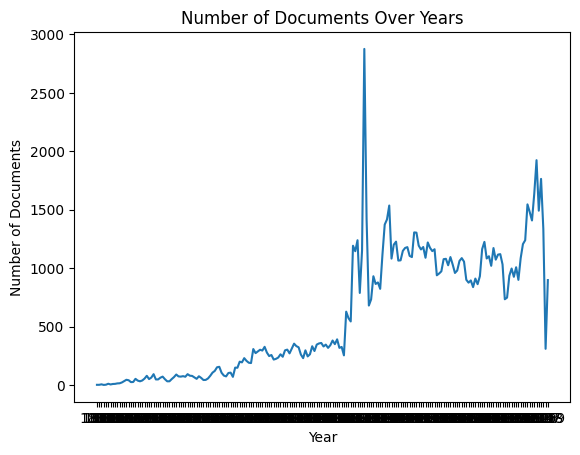

In [210]:
plt.plot(years, year_lens)
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.title('Number of Documents Over Years')
plt.show()

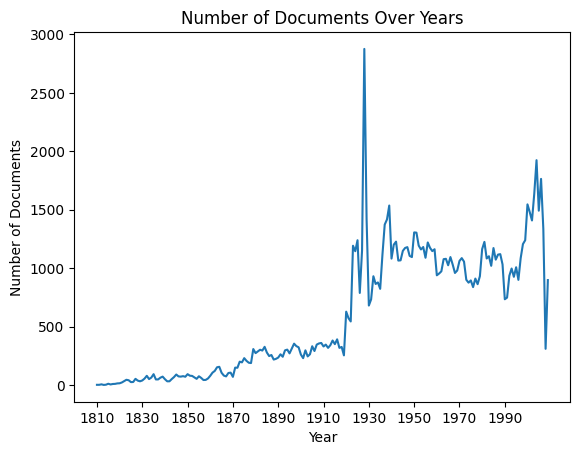

In [211]:
years_to_display = years[::20]

plt.plot(years, year_lens)
plt.xticks(years_to_display)
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.title('Number of Documents Over Years')
plt.show()

In [1]:
import random
sampling_ratio = 0.2

In [2]:
all_texts_coha = []
docs_per_timeslice = [0] * 5

In [ ]:

for i, year_info in enumerate(sorted(coha_yearseex4.keys())):
    large_files = 0

    sampled_articles = random.sample(coha_yearseex4[year_info], int(len(coha_yearseex4[year_info]) * sampling_ratio))

    for article in sampled_articles:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue

    if i < 70:
        docs_per_timeslice[0] += len(sampled_articles) - large_files
    elif 70 <= i < 103:
        docs_per_timeslice[1] += len(sampled_articles) - large_files
    elif 103 <= i < 140:
        docs_per_timeslice[2] += len(sampled_articles) - large_files
    elif 140 <= i < 180:
        docs_per_timeslice[3] += len(sampled_articles) - large_files
    elif i >= 180:
        docs_per_timeslice[4] += len(sampled_articles) - large_files


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
print("Total sampled articles:", len(all_texts_coha))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_timeslice, nums=50)


In [ ]:
final_corpus = []
docs_per_time_slice = [0] * 5


In [ ]:
for i, article in enumerate(small_corpusex4):

    if i < 100:
        time = 0
    if 100 < i <= 200:
        time = 1
    if 200 < i <= 300:
        time = 2
    if 300 < i <= 400:
        time = 3
    if 400 < i <= 500:
        time = 4

    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
print(ldaseq.print_topics(time=0)[1])

Some chunks took a very long time (more than 30 minutes), and I don't know if it's my problem or normal. In order to keep the job going, there are two chunks in Dynamic Topic Modelling that I decided to skip and move on. The code in exercise4 displays "rm has been used up" halfway through, so the work phase is terminated. I cannot confirm whether the results of each chunk are successful.
This job has many chunks that take a lot of time to run, which is very inconvenient for editing homework (sometimes I have to wait a very long time to proceed to the next stage of the job, or I have to skip). I don't know if there is any solution？